In [1]:
import numpy as np 
import pandas as pd
import random
import math
import time
from sklearn.metrics import confusion_matrix, accuracy_score  
import matplotlib.pyplot as plt  
import itertools 
from sklearn.model_selection import train_test_split

def normalize_to_0_1(dataset):

    mean_vals = np.mean(dataset, axis=0)
    std_vals = np.std(dataset, axis=0)
    
    standardized_data = (dataset - mean_vals) / std_vals
    
    return standardized_data  

def load_csv_data(file_path):
    
    data = pd.read_csv(file_path, header=None).to_numpy() 
    
    features = data[:, :-1]  
    labels = data[:, -1]  
    
    return features, labels.reshape(-1, 1)  

def encode_one_hot(labels):
    
    unique_labels, label_indices = np.unique(labels, return_inverse=True)  
    
    identity_matrix = np.eye(len(unique_labels))  
    
    one_hot_encoded = identity_matrix[label_indices] 
    
    return one_hot_encoded, unique_labels  


def visualize_confusion_matrix(true_labels, predicted_labels, class_names, plot_title, normalize=True, plot_size=(6,4), color_map=plt.cm.Blues):
    
    conf_matrix = confusion_matrix(np.argmax(true_labels, axis=1), np.argmax(predicted_labels, axis=1))  
    accuracy = accuracy_score(np.argmax(true_labels, axis=1), np.argmax(predicted_labels, axis=1))  
    
    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]  
        print("Normalized Confusion Matrix")  
    else:
        print('Confusion Matrix, without normalization')  
    
    width, height = plot_size  
    plt.figure(figsize=(width, height))  
    plt.imshow(conf_matrix, interpolation='nearest', cmap=color_map)  
    plt.title(f"{plot_title}\nAccuracy: {accuracy:.2f}")  
    plt.colorbar()  
    
    tick_marks = np.arange(len(class_names))  # ایجاد آرایه ای از شاخص های کلاس.
    plt.xticks(tick_marks, class_names, rotation=45)  # تنظیم نشانگرهای محور x با نام های کلاس ها به صورت چرخانده شده 45 درجه.
    plt.yticks(tick_marks, class_names)  # تنظیم نشانگرهای محور y با نام های کلاس ها.
    
    fmt = '.2f' if normalize else 'd'  # تنظیم قالب برای متن در سلول ها.
    threshold = conf_matrix.max() / 2.  # تعیین آستانه برای رنگ متن.
    
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):  # حلقه در ابعاد داده ها.
        plt.text(j, i, format(conf_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > threshold else "black")  # افزودن توضیحات متنی در سلول ها.
    
    plt.tight_layout()  # تنظیم طرح برای تناسب با عناصر.
    plt.ylabel('True label')  # تنظیم برچسب محور y.
    plt.xlabel('Predicted label')  # تنظیم برچسب محور x.
    plt.show()  # نمایش نمودار.

def plot_learning_curves(convergence_data):
    # تعریف تابع برای نمایش نمودارهای همگرایی.
    
    best_curve, mean_curve, worst_curve = convergence_data 
    plt.figure(figsize=(10, 4)) 
    
    plt.plot(best_curve[1:], color='green', label='Best') 
    plt.plot(mean_curve[1:], color='blue', label='Mean') 
    
    plt.title('Convergence Curves')
    plt.xlabel('Iteration')
    plt.ylabel('fitness')
    plt.legend()  
    plt.show() 

def sigmoid_function(x):

    return 1 / (1 + np.exp(-x))

class NeuralNetwork:
    def __init__(self, input_dim, hidden_units, output_units):

        self.input_dim = input_dim
        self.hidden_units = hidden_units
        self.output_units = output_units
        self.init_weights()  

    def init_weights(self):

        self.w1 = 2 * np.random.random((self.hidden_units, self.input_dim)) - 1  
        self.bias1 = np.zeros((self.hidden_units, 1))  
        self.w2 = 2 * np.random.random((self.output_units, self.hidden_units)) - 1  
        self.bias2 = np.zeros((self.output_units))  
        
        self.trainable_params = np.size(self.w1) + np.size(self.bias1) + np.size(self.w2) + np.size(self.bias2)

    def forward_pass(self, inputs):
        input_data = np.array(inputs, dtype='float32').reshape(-1, self.input_dim) 
        output_data = np.zeros((input_data.shape[0], self.output_units))  
        index = 0  
        for sample in input_data:  
            net_input_hidden = self.w1 @ sample.reshape(-1, 1) + self.bias1.reshape(-1, 1)  
            hidden_output = sigmoid_function(net_input_hidden)  
            net_input_output = self.w2 @ hidden_output.reshape(-1, 1) + self.bias2.reshape(-1, 1)  
            final_output = sigmoid_function(net_input_output)  
            output_data[index, :] = final_output.ravel()  
            index += 1  
        return output_data  

    def set_params_from_vector(self, params):
        parameter_vector = np.array(params, dtype='float32').ravel()  
        if np.size(parameter_vector) != self.trainable_params:
            raise ValueError('طول پارامترها برابر با تعداد پارامترهای قابل آموزش نیست') 
        index_1 = self.input_dim * self.hidden_units  
        self.w1 = parameter_vector[:index_1].reshape((self.hidden_units, self.input_dim))  
        index_2 = index_1 + self.hidden_units  
        self.bias1 = parameter_vector[index_1:index_2].reshape((self.hidden_units, 1))  
        index_3 = index_2 + self.output_units * self.hidden_units  
        self.w2 = parameter_vector[index_2:index_3].reshape((self.output_units, self.hidden_units))  
        self.bias2 = parameter_vector[index_3:].reshape((self.output_units))  

    def compute_mse(self, inputs, targets):
    
        predictions = self.forward_pass(inputs)  
        error = np.array(targets, dtype='float32') - predictions  
        return np.mean(error ** 2)  

def optimization_objective(params, inputs, targets, network):
    network.set_params_from_vector(params)  
    return network.compute_mse(inputs, targets)  

def objective_function(params, train_input, train_target, network):
    network.set_params_from_vector(params)  # Set the network parameters.
    return network.compute_mse(train_input, train_target)  # Return the MSE loss.

In [2]:
class OptimizationResult:
    def __init__(self):
        self.execution_time = None
        self.convergence_curve = None
        self.best_individual = None
        self.best_score = None

class OptimizationResult:
    def __init__(self):
        self.execution_time = None
        self.convergence_curve = None
        self.best_individual = None
        self.best_score = None

def MothFlameOptimizer(objective_function, dimensions, train_input, train_target,
                       neural_net_func, lower_bound=-1, upper_bound=1, num_moths=40, max_iterations=100, repeat=1):
    if not isinstance(lower_bound, list):
        lower_bound = [lower_bound] * dimensions
    if not isinstance(upper_bound, list):
        upper_bound = [upper_bound] * dimensions

    best_overall_score = float('inf')
    best_overall_position = None
    fitness_all_repeats = []

    start_time = time.time()
    
    for r in range(repeat):
        moth_positions = np.zeros((num_moths, dimensions))
        for i in range(dimensions):
            moth_positions[:, i] = np.random.uniform(0, 1, num_moths) * (upper_bound[i] - lower_bound[i]) + lower_bound[i]
        
        moth_fitness = np.full(num_moths, float("inf"))

        best_curve = np.zeros(max_iterations)
        worst_curve = best_curve.copy()
        mean_curve = best_curve.copy()

        sorted_population = np.copy(moth_positions)
        fitness_sorted = np.zeros(num_moths)

        best_flames = np.copy(moth_positions)
        best_flame_fitness = np.zeros(num_moths)

        double_population = np.zeros((2 * num_moths, dimensions))
        double_fitness = np.zeros(2 * num_moths)

        double_sorted_population = np.zeros((2 * num_moths, dimensions))
        double_fitness_sorted = np.zeros(2 * num_moths)

        previous_population = np.zeros((num_moths, dimensions))
        previous_fitness = np.zeros(num_moths)

        iteration = 1

        while iteration < max_iterations:
            flame_count = round(num_moths - iteration * ((num_moths - 1) / max_iterations))

            for i in range(num_moths):
                for j in range(dimensions):
                    moth_positions[i, j] = np.clip(moth_positions[i, j], lower_bound[j], upper_bound[j])
                moth_fitness[i] = objective_function(moth_positions[i, :], train_input, train_target, neural_net_func)

            if iteration == 1:
                fitness_sorted = np.sort(moth_fitness)
                sorted_indices = np.argsort(moth_fitness)
                sorted_population = moth_positions[sorted_indices, :]
                best_flames = sorted_population
                best_flame_fitness = fitness_sorted
            else:
                double_population = np.concatenate((previous_population, best_flames), axis=0)
                double_fitness = np.concatenate((previous_fitness, best_flame_fitness), axis=0)
                double_fitness_sorted = np.sort(double_fitness)
                sorted_indices_2 = np.argsort(double_fitness)

                for new_index in range(2 * num_moths):
                    double_sorted_population[new_index, :] = np.array(double_population[sorted_indices_2[new_index], :])

                fitness_sorted = double_fitness_sorted[:num_moths]
                sorted_population = double_sorted_population[:num_moths, :]
                best_flames = sorted_population
                best_flame_fitness = fitness_sorted

            best_flame_score = fitness_sorted[0]
            best_flame_position = sorted_population[0, :]
            previous_population = moth_positions
            previous_fitness = moth_fitness

            a = -1 + iteration * ((-1) / max_iterations)

            for i in range(num_moths):
                for j in range(dimensions):
                    if i <= flame_count:
                        distance_to_flame = abs(sorted_population[i, j] - moth_positions[i, j])
                        b = 1
                        t = (a - 1) * random.random() + 1
                        moth_positions[i, j] = (distance_to_flame * math.exp(b * t) * math.cos(t * 2 * math.pi)
                                                + sorted_population[i, j])
                    else:
                        distance_to_flame = abs(sorted_population[i, j] - moth_positions[i, j])
                        b = 1
                        t = (a - 1) * random.random() + 1
                        moth_positions[i, j] = (distance_to_flame * math.exp(b * t) * math.cos(t * 2 * math.pi)
                                                + sorted_population[flame_count, j])

            best_curve[iteration] = best_flame_score
            mean_curve[iteration] = np.mean(fitness_sorted)
            worst_curve[iteration] = fitness_sorted[-1]

            if iteration % 1 == 0:
                print(f"Repeat {r+1} - Iteration {iteration} / {max_iterations}     best fitness : {best_flame_score}")
                print('---------------------------------------')

            iteration += 1

        fitness_all_repeats.append(best_flame_score)

        if best_flame_score < best_overall_score:
            best_overall_score = best_flame_score
            best_overall_position = best_flame_position

    end_time = time.time()
    result = OptimizationResult()
    result.execution_time = end_time - start_time
    result.convergence_curve = (best_curve, mean_curve, worst_curve)
    result.best_individual = best_overall_position
    result.best_score = best_overall_score

    fitness_mean = np.mean(fitness_all_repeats)
    fitness_std = np.std(fitness_all_repeats)
    print(f"Mean fitness over all repeats: {fitness_mean}")
    print(f"Standard deviation of fitness over all repeats: {fitness_std}")

    return result


In [3]:
n_input_iris, n_hidden_iris, n_output_iris = 4, 9, 3  # Define the network architecture: 4 inputs, 9 hidden neurons, 3 outputs.
iris_classifier = NeuralNetwork(n_input_iris, n_hidden_iris, n_output_iris)  # Initialize the MLP classifier for Iris dataset.

n_input_breast, n_hidden_breast, n_output_breast = 9, 19, 1  # Define the network architecture: 9 inputs, 19 hidden neurons, 1 output.
breast_classifier = NeuralNetwork(n_input_breast, n_hidden_breast, n_output_breast)  # Initialize the MLP classifier for Breast Cancer dataset.

# Read and preprocess the Iris dataset.
X_iris, Y_iris = load_csv_data('iris.csv')  # Read Iris dataset.
# X_iris = normalize_to_0_1(X_iris)  # Normalize features (commented out).
Y_iris, unique_iris = encode_one_hot(Y_iris)  # One-hot encode target labels.

# Read and preprocess the Breast Cancer dataset.
X_breast, Y_breast = load_csv_data('breast-cancer-wisconsin.csv')  # Read Breast Cancer dataset.
X_breast = normalize_to_0_1(X_breast)  # Normalize features.
unique_breasts = np.unique(Y_breast)  # Get unique target labels.
Y_breast = np.where(Y_breast == unique_breasts[0], 0, 1)  # Convert targets to binary labels.

# Split the datasets into training and testing sets.
train_X_iris, test_X_iris, train_Y_iris, test_Y_iris = train_test_split(X_iris, Y_iris, test_size=0.2, shuffle=True)  # Split Iris dataset.
train_X_breast, test_X_breast, train_Y_breast, test_Y_breast = train_test_split(X_breast, Y_breast, test_size=0.2, shuffle=True)  # Split Breast Cancer dataset.


# Iris

In [4]:
# Train the MLP classifier for Iris dataset using MFO optimizer.
results_iris = MothFlameOptimizer(objective_function=objective_function, dimensions=iris_classifier.trainable_params, 
                                  train_input=train_X_iris, train_target=train_Y_iris, 
                                  neural_net_func=iris_classifier, num_moths=30, max_iterations=150 , repeat = 5)  # Run MFO optimization.


Repeat 1 - Iteration 1 / 150     best fitness : 0.22101732249327416
---------------------------------------
Repeat 1 - Iteration 2 / 150     best fitness : 0.22101732249327416
---------------------------------------
Repeat 1 - Iteration 3 / 150     best fitness : 0.21658751889658384
---------------------------------------
Repeat 1 - Iteration 4 / 150     best fitness : 0.206303236738339
---------------------------------------
Repeat 1 - Iteration 5 / 150     best fitness : 0.19213200413102854
---------------------------------------
Repeat 1 - Iteration 6 / 150     best fitness : 0.19213200413102854
---------------------------------------
Repeat 1 - Iteration 7 / 150     best fitness : 0.19213200413102854
---------------------------------------
Repeat 1 - Iteration 8 / 150     best fitness : 0.19213200413102854
---------------------------------------
Repeat 1 - Iteration 9 / 150     best fitness : 0.19213200413102854
---------------------------------------
Repeat 1 - Iteration 10 / 150 

Repeat 1 - Iteration 79 / 150     best fitness : 0.11664353080119624
---------------------------------------
Repeat 1 - Iteration 80 / 150     best fitness : 0.11664353080119624
---------------------------------------
Repeat 1 - Iteration 81 / 150     best fitness : 0.11664353080119624
---------------------------------------
Repeat 1 - Iteration 82 / 150     best fitness : 0.11536227009797795
---------------------------------------
Repeat 1 - Iteration 83 / 150     best fitness : 0.11536227009797795
---------------------------------------
Repeat 1 - Iteration 84 / 150     best fitness : 0.11295710918932242
---------------------------------------
Repeat 1 - Iteration 85 / 150     best fitness : 0.11295710918932242
---------------------------------------
Repeat 1 - Iteration 86 / 150     best fitness : 0.11295710918932242
---------------------------------------
Repeat 1 - Iteration 87 / 150     best fitness : 0.11295710918932242
---------------------------------------
Repeat 1 - Iteratio

Repeat 2 - Iteration 6 / 150     best fitness : 0.2036701105192224
---------------------------------------
Repeat 2 - Iteration 7 / 150     best fitness : 0.19349782537988855
---------------------------------------
Repeat 2 - Iteration 8 / 150     best fitness : 0.19349782537988855
---------------------------------------
Repeat 2 - Iteration 9 / 150     best fitness : 0.19349782537988855
---------------------------------------
Repeat 2 - Iteration 10 / 150     best fitness : 0.19349782537988855
---------------------------------------
Repeat 2 - Iteration 11 / 150     best fitness : 0.19349782537988855
---------------------------------------
Repeat 2 - Iteration 12 / 150     best fitness : 0.19315772953642088
---------------------------------------
Repeat 2 - Iteration 13 / 150     best fitness : 0.18600224397284842
---------------------------------------
Repeat 2 - Iteration 14 / 150     best fitness : 0.17017037100526317
---------------------------------------
Repeat 2 - Iteration 15 

Repeat 2 - Iteration 83 / 150     best fitness : 0.09624979106105659
---------------------------------------
Repeat 2 - Iteration 84 / 150     best fitness : 0.09624979106105659
---------------------------------------
Repeat 2 - Iteration 85 / 150     best fitness : 0.09624979106105659
---------------------------------------
Repeat 2 - Iteration 86 / 150     best fitness : 0.09617748126239682
---------------------------------------
Repeat 2 - Iteration 87 / 150     best fitness : 0.09428283420998343
---------------------------------------
Repeat 2 - Iteration 88 / 150     best fitness : 0.09428283420998343
---------------------------------------
Repeat 2 - Iteration 89 / 150     best fitness : 0.09428283420998343
---------------------------------------
Repeat 2 - Iteration 90 / 150     best fitness : 0.09428283420998343
---------------------------------------
Repeat 2 - Iteration 91 / 150     best fitness : 0.09426612901857975
---------------------------------------
Repeat 2 - Iteratio

Repeat 3 - Iteration 10 / 150     best fitness : 0.17545327602974048
---------------------------------------
Repeat 3 - Iteration 11 / 150     best fitness : 0.17545327602974048
---------------------------------------
Repeat 3 - Iteration 12 / 150     best fitness : 0.17545327602974048
---------------------------------------
Repeat 3 - Iteration 13 / 150     best fitness : 0.16878473277062803
---------------------------------------
Repeat 3 - Iteration 14 / 150     best fitness : 0.16878473277062803
---------------------------------------
Repeat 3 - Iteration 15 / 150     best fitness : 0.15261791408506764
---------------------------------------
Repeat 3 - Iteration 16 / 150     best fitness : 0.15261791408506764
---------------------------------------
Repeat 3 - Iteration 17 / 150     best fitness : 0.15261791408506764
---------------------------------------
Repeat 3 - Iteration 18 / 150     best fitness : 0.15261791408506764
---------------------------------------
Repeat 3 - Iteratio

Repeat 3 - Iteration 87 / 150     best fitness : 0.10736555133752197
---------------------------------------
Repeat 3 - Iteration 88 / 150     best fitness : 0.10654596878463332
---------------------------------------
Repeat 3 - Iteration 89 / 150     best fitness : 0.10554850527244246
---------------------------------------
Repeat 3 - Iteration 90 / 150     best fitness : 0.10554850527244246
---------------------------------------
Repeat 3 - Iteration 91 / 150     best fitness : 0.10554850527244246
---------------------------------------
Repeat 3 - Iteration 92 / 150     best fitness : 0.10554850527244246
---------------------------------------
Repeat 3 - Iteration 93 / 150     best fitness : 0.10346799274645273
---------------------------------------
Repeat 3 - Iteration 94 / 150     best fitness : 0.10257252785974053
---------------------------------------
Repeat 3 - Iteration 95 / 150     best fitness : 0.10257252785974053
---------------------------------------
Repeat 3 - Iteratio

Repeat 4 - Iteration 13 / 150     best fitness : 0.1812138883353003
---------------------------------------
Repeat 4 - Iteration 14 / 150     best fitness : 0.1812138883353003
---------------------------------------
Repeat 4 - Iteration 15 / 150     best fitness : 0.1812138883353003
---------------------------------------
Repeat 4 - Iteration 16 / 150     best fitness : 0.1812138883353003
---------------------------------------
Repeat 4 - Iteration 17 / 150     best fitness : 0.1812138883353003
---------------------------------------
Repeat 4 - Iteration 18 / 150     best fitness : 0.17481829786791178
---------------------------------------
Repeat 4 - Iteration 19 / 150     best fitness : 0.17481829786791178
---------------------------------------
Repeat 4 - Iteration 20 / 150     best fitness : 0.16840075816740646
---------------------------------------
Repeat 4 - Iteration 21 / 150     best fitness : 0.16118224706675433
---------------------------------------
Repeat 4 - Iteration 22 

Repeat 4 - Iteration 90 / 150     best fitness : 0.09576543118682786
---------------------------------------
Repeat 4 - Iteration 91 / 150     best fitness : 0.09480733573665741
---------------------------------------
Repeat 4 - Iteration 92 / 150     best fitness : 0.09480733573665741
---------------------------------------
Repeat 4 - Iteration 93 / 150     best fitness : 0.09420754225766584
---------------------------------------
Repeat 4 - Iteration 94 / 150     best fitness : 0.09420754225766584
---------------------------------------
Repeat 4 - Iteration 95 / 150     best fitness : 0.09420754225766584
---------------------------------------
Repeat 4 - Iteration 96 / 150     best fitness : 0.09237601205244833
---------------------------------------
Repeat 4 - Iteration 97 / 150     best fitness : 0.09237601205244833
---------------------------------------
Repeat 4 - Iteration 98 / 150     best fitness : 0.09237601205244833
---------------------------------------
Repeat 4 - Iteratio

Repeat 5 - Iteration 16 / 150     best fitness : 0.14584398367354542
---------------------------------------
Repeat 5 - Iteration 17 / 150     best fitness : 0.1432183116707028
---------------------------------------
Repeat 5 - Iteration 18 / 150     best fitness : 0.14283535688020027
---------------------------------------
Repeat 5 - Iteration 19 / 150     best fitness : 0.14283535688020027
---------------------------------------
Repeat 5 - Iteration 20 / 150     best fitness : 0.13500528212132584
---------------------------------------
Repeat 5 - Iteration 21 / 150     best fitness : 0.13500528212132584
---------------------------------------
Repeat 5 - Iteration 22 / 150     best fitness : 0.13500528212132584
---------------------------------------
Repeat 5 - Iteration 23 / 150     best fitness : 0.13332020593744653
---------------------------------------
Repeat 5 - Iteration 24 / 150     best fitness : 0.13332020593744653
---------------------------------------
Repeat 5 - Iteration

Repeat 5 - Iteration 94 / 150     best fitness : 0.10677974111833301
---------------------------------------
Repeat 5 - Iteration 95 / 150     best fitness : 0.10629307724910397
---------------------------------------
Repeat 5 - Iteration 96 / 150     best fitness : 0.10608297529022508
---------------------------------------
Repeat 5 - Iteration 97 / 150     best fitness : 0.10604677617494512
---------------------------------------
Repeat 5 - Iteration 98 / 150     best fitness : 0.10595417816033363
---------------------------------------
Repeat 5 - Iteration 99 / 150     best fitness : 0.10539011003625562
---------------------------------------
Repeat 5 - Iteration 100 / 150     best fitness : 0.10388921235004883
---------------------------------------
Repeat 5 - Iteration 101 / 150     best fitness : 0.10388921235004883
---------------------------------------
Repeat 5 - Iteration 102 / 150     best fitness : 0.10388921235004883
---------------------------------------
Repeat 5 - Itera

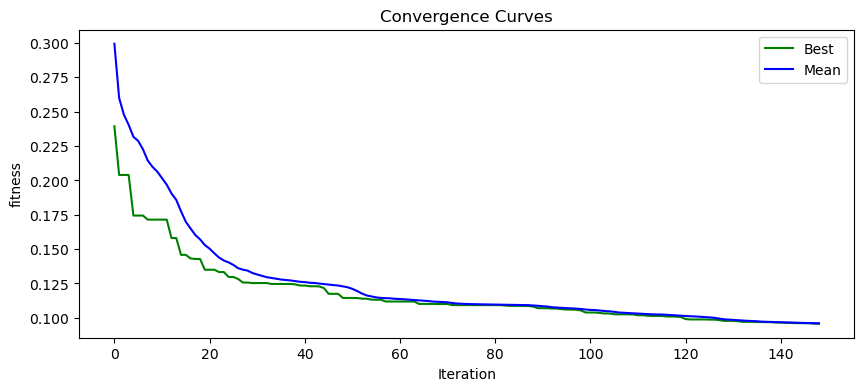

Confusion Matrix, without normalization


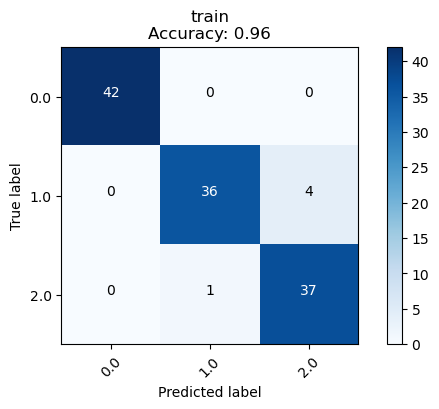

Confusion Matrix, without normalization


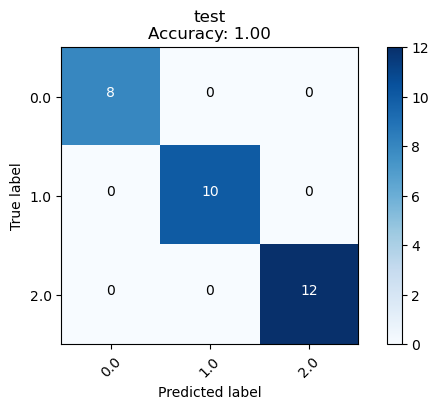

In [8]:
# Evaluate and plot results for Iris dataset.
best_params = results_iris.best_individual  # Get the best parameters.
iris_classifier.set_params_from_vector(best_params)  # Set the MLP parameters to the best found by MFO.

plot_learning_curves(results_iris.convergence_curve)  # Plot convergence curves for Iris dataset.

train_output = iris_classifier.forward_pass(train_X_iris)  # Predict on training data.

visualize_confusion_matrix(train_Y_iris, train_output, unique_iris, 'train', normalize=False)  # Plot confusion matrix for training data.
test_output = iris_classifier.forward_pass(test_X_iris)  # Predict on test data.

visualize_confusion_matrix(test_Y_iris, test_output, unique_iris, 'test', normalize=False)  # Plot confusion matrix for test data.


# Breast cancer

In [9]:
results_breast = MothFlameOptimizer(objective_function=objective_function, dimensions=breast_classifier.trainable_params, 
                                    train_input=train_X_breast, train_target=train_Y_breast, 
                                    neural_net_func=breast_classifier, num_moths=15, max_iterations=50 , repeat = 5)

Repeat 1 - Iteration 1 / 50     best fitness : 0.08687109668820313
---------------------------------------
Repeat 1 - Iteration 2 / 50     best fitness : 0.08687109668820313
---------------------------------------
Repeat 1 - Iteration 3 / 50     best fitness : 0.08687109668820313
---------------------------------------
Repeat 1 - Iteration 4 / 50     best fitness : 0.08687109668820313
---------------------------------------
Repeat 1 - Iteration 5 / 50     best fitness : 0.05769405001931462
---------------------------------------
Repeat 1 - Iteration 6 / 50     best fitness : 0.05769405001931462
---------------------------------------
Repeat 1 - Iteration 7 / 50     best fitness : 0.05769405001931462
---------------------------------------
Repeat 1 - Iteration 8 / 50     best fitness : 0.05711248845119641
---------------------------------------
Repeat 1 - Iteration 9 / 50     best fitness : 0.05711248845119641
---------------------------------------
Repeat 1 - Iteration 10 / 50     best

Repeat 2 - Iteration 29 / 50     best fitness : 0.021475281109103114
---------------------------------------
Repeat 2 - Iteration 30 / 50     best fitness : 0.021036257455933106
---------------------------------------
Repeat 2 - Iteration 31 / 50     best fitness : 0.020940225525787164
---------------------------------------
Repeat 2 - Iteration 32 / 50     best fitness : 0.02069684991296035
---------------------------------------
Repeat 2 - Iteration 33 / 50     best fitness : 0.02069684991296035
---------------------------------------
Repeat 2 - Iteration 34 / 50     best fitness : 0.020138048488786402
---------------------------------------
Repeat 2 - Iteration 35 / 50     best fitness : 0.020138048488786402
---------------------------------------
Repeat 2 - Iteration 36 / 50     best fitness : 0.019979711229794146
---------------------------------------
Repeat 2 - Iteration 37 / 50     best fitness : 0.01949053070986608
---------------------------------------
Repeat 2 - Iteration 3

Repeat 4 - Iteration 8 / 50     best fitness : 0.0664863236857172
---------------------------------------
Repeat 4 - Iteration 9 / 50     best fitness : 0.042022851560646196
---------------------------------------
Repeat 4 - Iteration 10 / 50     best fitness : 0.0392594962776624
---------------------------------------
Repeat 4 - Iteration 11 / 50     best fitness : 0.0392594962776624
---------------------------------------
Repeat 4 - Iteration 12 / 50     best fitness : 0.0392594962776624
---------------------------------------
Repeat 4 - Iteration 13 / 50     best fitness : 0.02942287200508896
---------------------------------------
Repeat 4 - Iteration 14 / 50     best fitness : 0.02942287200508896
---------------------------------------
Repeat 4 - Iteration 15 / 50     best fitness : 0.02942287200508896
---------------------------------------
Repeat 4 - Iteration 16 / 50     best fitness : 0.028806425373361616
---------------------------------------
Repeat 4 - Iteration 17 / 50    

Repeat 5 - Iteration 35 / 50     best fitness : 0.01954423633017809
---------------------------------------
Repeat 5 - Iteration 36 / 50     best fitness : 0.01954423633017809
---------------------------------------
Repeat 5 - Iteration 37 / 50     best fitness : 0.019262850947960816
---------------------------------------
Repeat 5 - Iteration 38 / 50     best fitness : 0.019245622230720048
---------------------------------------
Repeat 5 - Iteration 39 / 50     best fitness : 0.019232360215292663
---------------------------------------
Repeat 5 - Iteration 40 / 50     best fitness : 0.018778850315274605
---------------------------------------
Repeat 5 - Iteration 41 / 50     best fitness : 0.018778850315274605
---------------------------------------
Repeat 5 - Iteration 42 / 50     best fitness : 0.018296221693327078
---------------------------------------
Repeat 5 - Iteration 43 / 50     best fitness : 0.018296221693327078
---------------------------------------
Repeat 5 - Iteration 

Confusion Matrix, without normalization


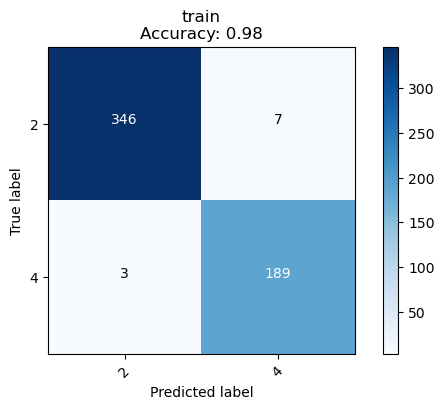

Confusion Matrix, without normalization


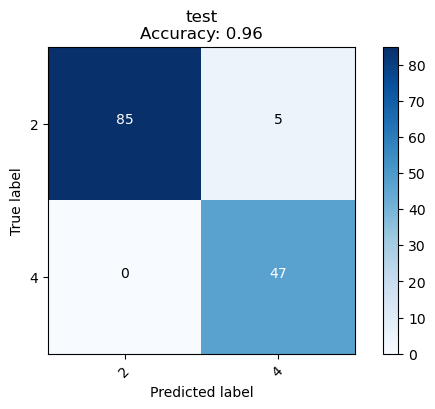

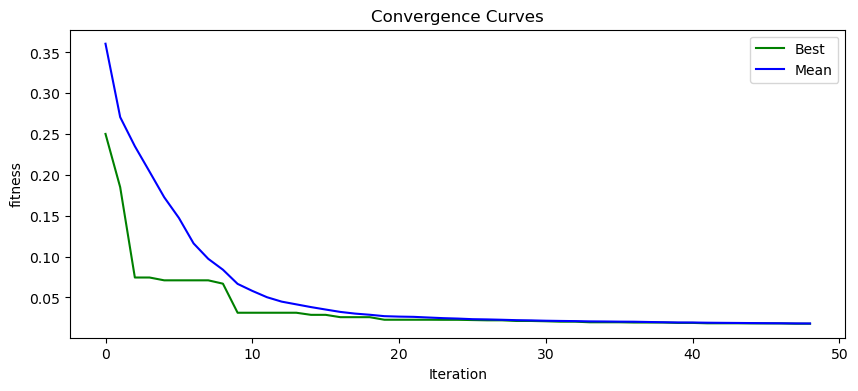

In [10]:
# Evaluate and plot results for Breast Cancer dataset.
best_params = results_breast.best_individual  # Get the best parameters.
breast_classifier.set_params_from_vector(best_params)  # Set the MLP parameters to the best found by MFO.
train_output = breast_classifier.forward_pass(train_X_breast)  # Predict on training data.
train_output = np.where(train_output < 0.5, 0, 1)  # Convert predictions to binary labels.
train_output, _ = encode_one_hot(train_output)  # One-hot encode the predictions.
train_target, _ = encode_one_hot(train_Y_breast)  # One-hot encode the true labels.
visualize_confusion_matrix(train_target, train_output, unique_breasts, 'train', normalize=False)  # Plot confusion matrix for training data.

test_output = breast_classifier.forward_pass(test_X_breast)  # Predict on test data.
test_output = np.where(test_output < 0.5, 0, 1)  # Convert predictions to binary labels.
test_output, _ = encode_one_hot(test_output)  # One-hot encode the predictions.
test_target, _ = encode_one_hot(test_Y_breast)  # One-hot encode the true labels.
visualize_confusion_matrix(test_target, test_output, unique_breasts, 'test', normalize=False)  # Plot confusion matrix for test data.

plot_learning_curves(results_breast.convergence_curve)  # Plot convergence curves for Breast Cancer dataset.
